M1.2
Bjarke Schrøder Andersen

Pre-processing: Dataset bliver hentet. Pakker bliver indlæst. Advarsler om fremtidige ændringer i pakker bliver ikke veist fremadrettet.

In [55]:
!wget -c https://github.com/SDS-AAU/M1-2019/raw/master/data/pokemon.csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype as isn
from sklearn.cluster import KMeans as km
from sklearn.decomposition import PCA 
from sklearn.linear_model import LogisticRegression as lr
from sklearn.metrics import classification_report as cr
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score as cvs
from sklearn.model_selection import GridSearchCV as gscv
from sklearn.model_selection import train_test_split as tts
from sklearn.neighbors import KNeighborsClassifier as knc
from sklearn.pipeline import make_pipeline as mpipe
from sklearn.pipeline import Pipeline as pipe
from sklearn.preprocessing import StandardScaler as ss
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as dtc
from warnings import simplefilter
simplefilter(action='ignore', category=(FutureWarning,DeprecationWarning))

--2019-09-18 05:05:52--  https://github.com/SDS-AAU/M1-2019/raw/master/data/pokemon.csv
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/SDS-AAU/M1-2019/master/data/pokemon.csv [following]
--2019-09-18 05:05:52--  https://raw.githubusercontent.com/SDS-AAU/M1-2019/master/data/pokemon.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



Opgave 1 Unsupervised. Data læses.

In [0]:
df = pd.read_csv('pokemon.csv')

Opgave 1.a. PCA laves på de numeriske data.

In [57]:
pca = PCA(n_components=4)
scale = ss()
sample = df.select_dtypes(include=['float64', 'int64'])
scale.fit(sample)
samples = scale.transform(sample)
pca.fit(samples)
pca.explained_variance_ratio_.cumsum()

array([0.34566246, 0.58803627, 0.72409096, 0.82128477])

Opgave 1.b

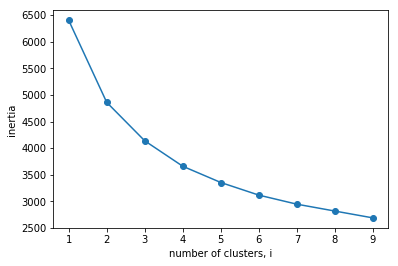

In [58]:
ks = range(1, 10)
inertias = []
kscale = ss()
ksample = df.select_dtypes(include=['float64', 'int64'])
kscale.fit(ksample)
ksamples = kscale.transform(ksample)

for i in ks:
    model = km(n_clusters=i)
    model.fit(ksamples)
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, i')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

På gaggrund af plottet vælges antallet af clustre til 4

In [59]:
model = km(n_clusters=4)
model.fit(ksamples)
labels = model.predict(ksamples)
print('')

Opgave 1.c. Der laves PCA på data og der plottets med farve efter cluster

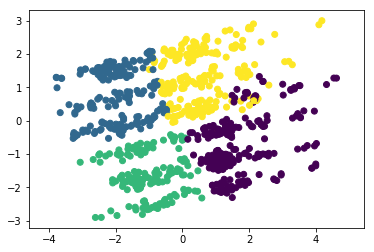

In [60]:
sample = pca.fit_transform(ksamples)
xs = sample[:,0]
ys = sample[:,1]
plt.scatter(xs, ys, c=labels)
plt.axis('equal')
plt.show()

Opgave 1.d. 'Labels' splejses med datasættet så de kan sammenlignes med clusters.

In [61]:
lab = pd.DataFrame(labels)
lab.columns = ['Clusters']
df1 = df.join(lab)
pd.crosstab(df1.Type1,df1.Clusters)

Clusters,0,1,2,3
Type1,,,,
Bug,11,24,20,14
Dark,12,4,8,7
Dragon,20,2,5,5
Electric,15,10,9,10
Fairy,6,4,4,3
Fighting,8,5,5,9
Fire,13,12,10,17
Flying,3,0,1,0
Ghost,14,4,9,5


Nej, algoritmen adskiller ikke de forskellige typer af pokemons

Opgave 2. Supervised.

Opgave 2.a
Navnene er unikke og droppes. 'Type1' opdeles i dummy-variablerså data i datasættet er numerisk. Den første dummy droppes for at undgå at angive allerede implicit givet data. Der kan argumenteres for skalering, men forklaringsgraden falder hvis data skaleres.


Derefter skaleres datasættet til værdier fra 0 til 1

In [0]:
df = pd.read_csv('pokemon.csv')
df = df.drop('Name', 1)
df = pd.get_dummies(df, drop_first=True)

Opgave 2.b

In [0]:
train, test = tts(df, test_size=0.25)

a = train['Legendary'].values
b = train.drop('Legendary', axis=1).values
c = test['Legendary'].values
d = test.drop('Legendary', axis=1).values

Opgave 2.c. In this case, n=25

In [64]:
reg = lr()
cvs2a = cvs(reg, b, a, cv=25)

print("Average 25-Fold CV Score: {}".format(np.mean(cvs2a)))

Average 25-Fold CV Score: 0.9368492753623188


Opgave 2.d Der laves en logistisk regression, et decision tree og en pipeline model.


In [65]:
reg = lr()
reg.fit(b,a)

tree = dtc()
tree.fit(b,a)

param = {'SVM__C':[1, 10, 100],'SVM__gamma':[0.1, 0.01]}
trin = [('SVM', SVC())]
rør = pipe(trin)
rørmodel = gscv(rør, param, cv=25)
rørmodel.fit(b,a)
print('')

Opgave 2.e

In [66]:
reg_p = reg.predict(d)
tree_p = tree.predict(d)
rør_p = rørmodel.predict(d)

cm(c,reg_p)
cm(c,tree_p)
cm(c,rør_p)

array([[182,   0],
       [ 17,   1]])

Opgave 2.f. Resultaterne ændrer sig hver gang koderne bliver kørt, men rørmodellen kommer som regel ud bedst. 

In [67]:
print('\n','Logistic regression:','\n','{}'.format(cm(c,reg_p)),'\n','\n','Decision tree:','\n','{}'.format(cm(c,tree_p)),'\n','\n','SVM pipeline regression:','\n','{}'.format(cm(c,rør_p)))


 Logistic regression: 
 [[182   0]
 [ 10   8]] 
 
 Decision tree: 
 [[177   5]
 [ 11   7]] 
 
 SVM pipeline regression: 
 [[182   0]
 [ 17   1]]


Konklusion: Rørmodellen med tunede parametre er bedst